In [1]:
# Ex3
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
HP = {'num_epochs': 10,
       'learning_rate': .002,
       'batch_size': 50,
       'num_classes': 10}

In [3]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

In [4]:
# MNIST fashion dataset
train_dataset = datasets.FashionMNIST('data_fashionMNIST', train = True, transform = trans, download = True)
test_dataset = datasets.FashionMNIST('data_fashionMNIST', train = False, transform = trans)
# Data loader
train_loader = DataLoader(dataset = train_dataset, batch_size = HP['batch_size'], shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = HP['batch_size'], shuffle = False)

Extracting data_fashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to data_fashionMNIST\FashionMNIST\raw


Extracting data_fashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data_fashionMNIST\FashionMNIST\raw


Extracting data_fashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data_fashionMNIST\FashionMNIST\raw




Extracting data_fashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data_fashionMNIST\FashionMNIST\raw
Processing...
Done!


In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7*7*64,1000)
        self.fc2 = nn.Linear(1000,10)
    def forward(self, x):
        z1 = F.relu(self.conv1(x))
        z2 = self.pool1(z1)
        z3 = F.relu(self.conv2(z2))
        z4 = self.pool2(z3)
        s = self.drop_out(z4.reshape(z4.size(0),-1))
        z5 = self.fc1(s)
        z6 = self.fc2(z5)
        return z5

In [6]:
model = ConvNet()
#Loss function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = HP['learning_rate'])
#Frame setup for results
N_train = len(train_dataset)   
N_test = len(test_dataset)     
#t0 = time.time()
df = pd.DataFrame(columns=('epoch', 'loss_train','loss_test', 'accuracy_train','accuracy_test'))
total_step = len(train_loader)

In [7]:
for epoch in range(HP['num_epochs']):
    print('-- epoch ' + str(epoch))
    running_loss_train = 0.0
    accuracy_train = 0.0
    model.train()
    for i, (X, y) in enumerate(train_loader):
        # forward pass, compute the scores and loss
        scores = model(X)
        loss = criterion(scores, y)
        # backprop and optimization, initialize the gradient "∇ loss" to zero
        optimizer.zero_grad()
        # estimate the gradient (back propagation)
        loss.backward()
        # update the parameters
        optimizer.step()
        # estimate the loss and accuracy
        running_loss_train += loss.detach().numpy()
        accuracy_train += (scores.argmax(dim=1) == y).sum().numpy()
    #test model
    model.eval()
    with torch.no_grad():
        accuracy_test = 0.0
        running_loss_test = 0.0
        for X, y in test_loader:
            scores = model(X)
            loss = criterion(scores, y)
            _, predicted = torch.max(scores.data, 1)
            running_loss_test += loss.detach().numpy()
            accuracy_test += (scores.argmax(dim=1) == y).sum().numpy()      
#calculate loss and accuracy, store values
    # normalize
    accuracy_train /= N_train
    accuracy_test /= N_test
    average_loss_train = running_loss_train/N_train*HP['batch_size']
    average_loss_test = running_loss_test/N_test*HP['batch_size']
    print('loss ====='+str(average_loss_train))
    print('loss ====='+str(average_loss_test))
    print(' accuracy (train, test): {:.4f}, {:.4f}'.format(accuracy_train, accuracy_test))
    #print('accuracy (train/test) : '+str(accuracy_train)+' '+str(accuracy_test))
    df.loc[epoch] = [epoch, average_loss_train,average_loss_test, accuracy_train, accuracy_test]

-- epoch 0
loss =====0.4841986516366402
loss =====0.33820333652198314
 accuracy (train, test): 0.8298, 0.8789
-- epoch 1
loss =====0.33261330634976427
loss =====0.29208550572395325
 accuracy (train, test): 0.8814, 0.8966
-- epoch 2
loss =====0.2943026468716562
loss =====0.28337076999247074
 accuracy (train, test): 0.8947, 0.8991
-- epoch 3
loss =====0.2767421582372238
loss =====0.25830568827688694
 accuracy (train, test): 0.8997, 0.9079
-- epoch 4
loss =====0.26106405118169884
loss =====0.2569559730216861
 accuracy (train, test): 0.9053, 0.9101
-- epoch 5
loss =====0.24771348300700385
loss =====0.2548133233003318
 accuracy (train, test): 0.9102, 0.9089
-- epoch 6
loss =====0.24222437724781531
loss =====0.24508908145129682
 accuracy (train, test): 0.9123, 0.9119
-- epoch 7
loss =====0.23476914980138341
loss =====0.2477314309589565
 accuracy (train, test): 0.9156, 0.9125
-- epoch 8
loss =====0.22840323630099493
loss =====0.24232914909720424
 accuracy (train, test): 0.9172, 0.9135
-- epoc

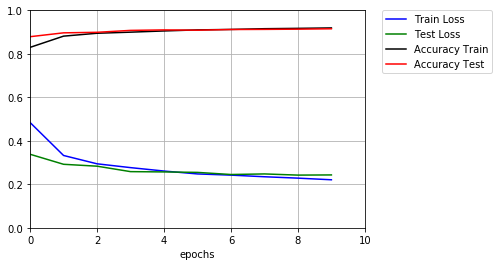

In [8]:
plt.plot(df['epoch'],df['loss_train'],color='blue', label= r'Train Loss') 
plt.plot(df['epoch'],df['loss_test'],color='green', label= r'Test Loss')
plt.plot(df['epoch'],df['accuracy_train'],color='black', label= r'Accuracy Train')
plt.plot(df['epoch'],df['accuracy_test'],color='red', label= r'Accuracy Test')
plt.axis([0, HP['num_epochs'], 0, 1])
plt.grid()
plt.xlabel('epochs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()